---
layout: post
title: A Biologically-Plausible Learning Rule
date: 2023-09-06
category: AI
tags: deep-learning, julia, neuroai
---

Today, [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) is basically synonymous with artificial neural networks (ANNs). The algorithm has proven to be incredibly effective in adjusting--and ultimately selecting--model weights by computing the gradient of a loss function with respect to the weights, via an application of the chain rule.  However effective this may be in training ANNs, it lacks biological plausibility. In a recent [paper by Dellaferrera and Kreiman (2022)](https://arxiv.org/pdf/2201.11665.pdf), the researchers outline four such inconsistencies with neuroscience $^1$:

1. The same weights are used both in the forward pass and in the backward pass, which is known as the *weight symmetry/weight transport problem*. $^2$
2. The parameter updates depend on the activity of all downstream nodes, while synapses in the nervous system learn based on *local signals*. $^3$
3. Error gradients are stored separately from the activations  and do not influence the activities of the nodes produced in the forward pass. During the backward pass, network activity is *frozen*. $^4$
4. Each sample needs to wait for both the forward and backward passes to be completed for the previous sample. This is referred to as the *update locking problem*. $^{5,6}$

The paper then introduces a more biologically plausible learning algorithm, coined *Present the Error to Perturb the Input To modulate Activity (PEPITA)*. PEPITA removes the backward pass of backpropagation and instead uses two forward passes per sample. The error of the first forward pass is projected onto the input for the second pass. This is akin to global modulatory signals present in the brain. Here, I implement and experiment with this algorithm in Julia.

In [1]:
using Random
using Distributions
using Noise
using Plots
Random.seed!(99);

We will create a struct to store model weights and a method that passes input through a network and returns the hidden layer activities and the scalar output.

In [2]:
mutable struct ModelWeights
    w1::Array
    w2::Array
end

function forwardPass(W::ModelWeights, X::Array)
    activity1 = X * W.w1
    activity1 = max.(activity1, 0) #ReLU activation
    output = activity1 * W.w2
    return activity1, output
end

forwardPass (generic function with 1 method)

We can then build a simple, densely connected ground truth network. The input layer takes a vector of length 16, there are 8 hidden units, and a scalar output node. 


![](nn.png)

In [3]:
w1 = rand(Normal(0,0.5), (16, 8))    
w2 = rand(Normal(0,0.5), (8, 1))
trueModel = ModelWeights(w1, w2);

Then, we draw 1,000 and 500 training and validation samples, respectively, and pass them through the true model, to generate targets from which we can assess the trained model.

In [4]:
xTrain = rand(Float64, (1000, 16))
yTrain = forwardPass(trueModel, xTrain)[2]

xVal = rand(Float64, (500, 16))
yVal = forwardPass(trueModel, xVal)[2];

Now, the algorithm.

In [5]:
# randomly initialize model weights
w1Init = rand(Uniform(-0.5,0.5), (16,8))
w2Init = rand(Uniform(-0.5,0.5), (8,1))

# initialize the projection matrix, denoted F in Dellaferrera & Kreiman (2022)
F = rand(Uniform(-0.03,0.03), (1,16))

# initilize a model to be trained
fitModel = ModelWeights(w1Init, w2Init)

# hyperparameters
nEpochs = 100000
η = 5e-4

# track mean absolute error
maeTrain = Array{Float64}(undef, nEpochs)
maeVal = Array{Float64}(undef, nEpochs)

for epoch in range(1, nEpochs)
   # standard pass
   activity, ŷ = forwardPass(fitModel, xTrain)
   error = ŷ - yTrain

   # modulated pass
   xMod = xTrain + error*F
   activityError, _ = forwardPass(fitModel, xMod)
   Δw1 = transpose(xMod)*(activity - activityError)
   Δw2 = transpose(activityError)*error
   # optimization step
   fitModel.w1 = fitModel.w1 - η*Δw1
   fitModel.w2 = fitModel.w2 - η*Δw2
   
   _, ŷ = forwardPass(fitModel, xTrain)
   maeTrain[epoch] = mean(abs.(ŷ - yTrain))

   _, ŷ = forwardPass(fitModel, xVal)
   maeVal[epoch] = mean(abs.(ŷ - yVal))
end

Let's see how the mean absolute error (MAE) improved during training.

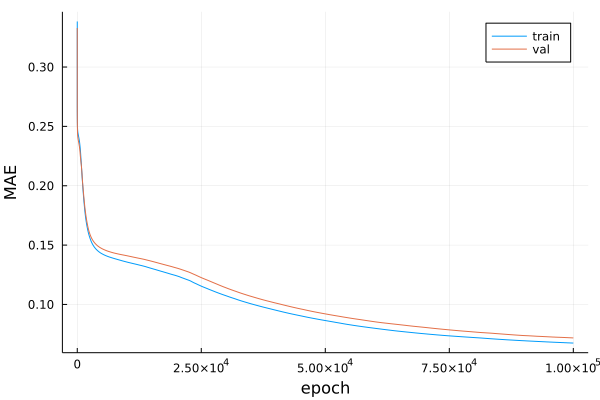

In [6]:
plot(range(1,nEpochs), [maeTrain, maeVal], label=["train" "val"])
xlabel!("epoch")
ylabel!("MAE")

$^1$ Dellaferrera, G., & Kreiman, G. (2023). Error-driven Input Modulation: Solving the Credit Assignment Problem without a Backward Pass (arXiv:2201.11665). arXiv. https://doi.org/10.48550/arXiv.2201.11665

$^2$ Burbank, K. and Kreiman, G. Depression-biased reverse
plasticity rule is required for stable learning at top-down
connections. *PLoS Computational Biology*, 8:1–16, 2012.

$^3$ Whittington, J. and Bogacz, R. Theories of error backpropagation in the brain. *Trends in Cognitive Sciences*,
23:235–250, 03 2019.

$^4$ Liao, Q., Leibo, J. Z., and Poggio, T. How important is
weight symmetry in backpropagation?, 2016.

$^5$ Jaderberg, M., Czarnecki, W. M., Osindero, S., Vinyals,
O., Graves, A., Silver, D., and Kavukcuoglu, K. Decoupled neural interfaces using synthetic gradients. In
*Proceedings of the 34th International Conference on Machine Learning - Volume 70*, ICML’17, pp. 1627–1635.
JMLR.org, 2017.

$^6$ Czarnecki, W. M., Swirszcz, G., Jaderberg, M., Osindero,
S., Vinyals, O., and Kavukcuoglu, K. Understanding
synthetic gradients and decoupled neural interfaces. In
*Proceedings of the 34th International Conference on Machine Learning - Volume 70*, ICML’17, pp. 904–912.
JMLR.org, 2017. 